<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Planet-Kaggle-competition" data-toc-modified-id="Planet-Kaggle-competition-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Planet Kaggle competition</a></span></li></ul></li><li><span><a href="#Data-preparation-steps-if-you-are-using-Crestle:" data-toc-modified-id="Data-preparation-steps-if-you-are-using-Crestle:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation steps if you are using Crestle:</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Evaluate</a></span></li><li><span><a href="#End" data-toc-modified-id="End-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>End</a></span></li></ul></li></ul></li></ul></div>

## Planet Kaggle competition

Based on [Notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson2-image_models.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data preparation steps if you are using Crestle:
```
os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}
```

In [9]:
from fastai.conv_learner import *
bs=64; f_model = resnet34
PATH = "/data/planet/"
#torch.cuda.set_device(1)

In [10]:
n=len(list(open(f'{PATH}train_v2.csv')))-1

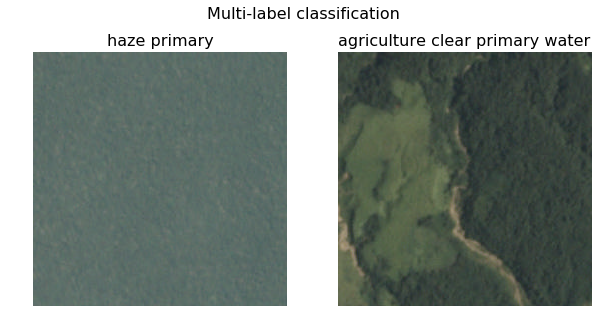

In [12]:
from fastai.plots import *
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: haze and primary. The second image belongs to four clases: agriculture, clear, primary and water.

Code differences:

- transforms_top_down — Since they satellite imagery, they still make sense when they were flipped vertically.
- Much higher learning rate — something to do with this particular dataset
    - lrs = np.array([lr/9,lr/3,lr]) — discriminative learning rate now change by 3x because images are quite different from ImageNet images
- sz=64 — this helped avoid over fitting for satellite images.
(but not for similar images to ImageNet as 64x64 is quite tiny and might destroy pre-trained weights.

In [13]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [14]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.
- `transform_top_down` : it does more than just a vertical flip. There are 8 possible symmetries for a square — it can be rotated through 0, 90, 180, 270 degrees and for each of those, it can be flipped (dihedral group of eight)

In [15]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

One of the things the data loader does is to resize the images on-demand. This has nothing to do with data.resize . If the initial image is 1000 by 1000, reading that JPEG and resizing it to 64 by 64 take more time than training the convolutional net. data.resize tells it that we will not use images bigger than sz*1.3 so go through once and create new JPEGs of this size. Since images are rectangular, so new JPEGs whose smallest edge is sz*1.3 (center-cropped). It will save you a lot of time.

In [16]:
#data=get_data_pad(f_model, path, 256, 64, n, 0)

In [17]:
data = get_data(256)

`x` : a mini-batch of images, `y` : a mini-batch of labels.

In [18]:
x,y =  next(iter(data.val_dl))

We had seen data.val_ds , test_ds, train_ds(ds: dataset) for which you can get an individual image by data.train_ds[0], for example.
dl is a data loader which will give you a mini-batch, specifically transformed mini-batch. 
With a data loader, you cannot ask for a particular mini-batch; you can only get back the next mini-batch. In Python, it is called “generator” or “iterator”. PyTorch really leverages modern Python methodologies.

In [19]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

One-hot-encoding is terribly inefficient for storing, so we will store an index value (single integer) rather than 0’s and 1’s for the target value (y) [1:31:21]. If you look at the y values for the dog breeds competition, you won’t actually see a big lists of 1’s and 0's, but you will wee a single integer. And internally, PyTorch is converting the index to one-hot-encoded vector (even though you will literally never see it). PyTorch has different loss functions for ones that are one hot encoded and others that are not — but these details are hidden by the fast.ai library so you do not have to worry about it. But the cool thing to realize is that we are doing exactly the same thing for both single label classification and multi label classification.



In [5]:
learn = Learner.pretrained_convnet(f_model, data, metrics=[f2])

Instead of accuracy, we used F-beta, a way of weighing false negatives and false positives. 
Because this particular Kaggle competition wants to use it. 
Take a look at planet.py to see how you can create your own metrics function. This is what gets printed out at the end [ 0. 0.08932 0.08218 0.9324 ]

In [20]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

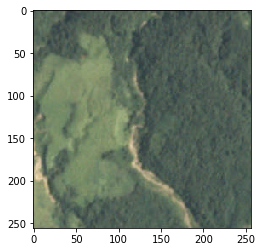

In [21]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

*1.4 : The image was washed out, so making it more visible (“brightening it up a bit”). Images are just matrices of numbers, so we can do things like this.
It is good to experiment images like this because these images are not at all like ImageNet. The vast majority of things you do involving convolutional neural net will not actually be anything like ImageNet (medical imaging, classifying different kinds of steel tube, satellite images, etc)

In [22]:
sz=64
data = get_data(sz)

In [23]:
data = data.resize(int(sz*1.3),'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

We will not use sz=64 for cats and dogs competition because we started with pre-trained ImageNet network which starts off nearly perfect. If we re-trained the whole set with 64 by 64 images, we would destroy the weights that are already very good. Remember, most of ImageNet models are trained with 224 by 224 or 299 by 299 images.

There is no images in ImageNet that looks like the one above. And only the first couple layers are useful to us. So starting out with smaller images works well in this case.

In [24]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.230647   0.346527   0.793435  



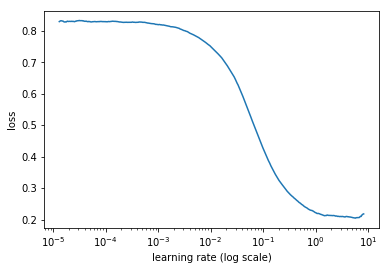

In [25]:
lrf=learn.lr_find()
learn.sched.plot()

In [26]:
lr = 0.2

In [27]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.14958    0.134497   0.883047  
    1      0.142021   0.130469   0.885442                    
    2      0.137027   0.127927   0.888309                    
    3      0.137877   0.127444   0.889668                    
    4      0.131931   0.1251     0.890187                    
    5      0.133916   0.123685   0.892907                    
    6      0.130426   0.123356   0.892628                    



[array([0.12336]), 0.8926275978171818]

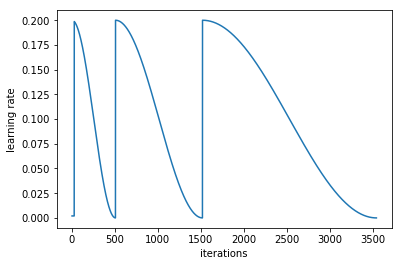

In [28]:
learn.sched.plot_lr()

In [29]:
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()

In [31]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.100617   0.097589   0.918629  
    1      0.104764   0.100128   0.916166                     
    2      0.098277   0.097008   0.919358                     
    3      0.10243    0.100937   0.915431                    
    4      0.099543   0.098784   0.916168                     
    5      0.093213   0.096429   0.91917                      
    6      0.093533   0.096076   0.919936                     



[array([0.09608]), 0.9199358997766187]

In [32]:
learn.fit([1e-4,1e-3,0.01], 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.089754   0.096389   0.919101  
    1      0.092517   0.096171   0.919188                     
    2      0.087667   0.095983   0.919769                     
    3      0.09142    0.09605    0.919717                     



[array([0.09605]), 0.9197170265893404]

In [33]:
learn.save(f'{sz}')

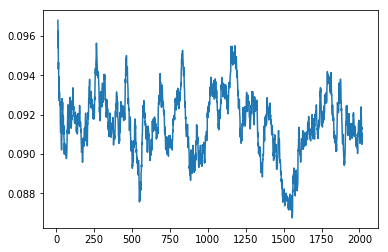

In [34]:
learn.sched.plot_loss()

### Evaluate

In [35]:
name = '170809'

In [41]:
def get_data(path, tfms,bs,  n, cv_idx):
    val_idxs = get_cv_idxs(n, cv_idx)
    return ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms,
                                 suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

def get_data_zoom(f_model, path, sz, bs, n, cv_idx):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return get_data(path, tfms, bs, n, cv_idx)

def get_data_pad(f_model, path, sz, bs, n, cv_idx):
    transforms_pt = [RandomRotateZoom(9, 0.18, 0.1), RandomLighting(0.05, 0.1), RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_pt, pad=sz//12)
    return get_data(path, tfms, bs, n, cv_idx)

In [42]:
def load_cycle_cv(cv, cycle):
    data=get_data_zoom(f_model, path, 256, 64, n, cv)
    learn.set_data(data)
    learn.load_cycle(f'{name}_{cv}', cycle)
    return data

In [43]:
#data = load_cycle_cv(0,1)

FileNotFoundError: [Errno 2] No such file or directory: '/data/planet/tmp/83/models/170809_0_cyc_1.h5'

In [44]:
val = learn.predict()

In [45]:
f2(val,data.val_y)

0.8321111567722022

In [46]:
f2(learn.TTA(),data.val_y)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [47]:
f2(val,data.val_y)

0.8321111567722022

In [48]:
f2(learn.TTA(),data.val_y)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [49]:
def get_labels(a): return [data.classes[o] for o in a.nonzero()[0]]

lbls = test>0.2
idx=9
print(get_labels(lbls[idx]))
PIL.Image.open(path+data.test_dl.dataset.fnames[idx]).convert('RGB')

NameError: name 'test' is not defined

In [ ]:
res = [get_labels(o) for o in lbls]
data.test_dl.dataset.fnames[:5]

In [ ]:
outp = pd.DataFrame({'image_name': [f[9:-4] for f in data.test_dl.dataset.fnames],
        'tags': [' '.join(l) for l in res]})
outp.head()

In [ ]:
outp.to_csv('tmp/subm.gz', compression='gzip', index=None)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('tmp/subm.gz')

In [ ]:
def cycle_preds(name, cycle, n_tta=4, is_test=False):
    learn.load_cycle(name, cycle)
    return learn.TTA(n_tta, is_test=is_test)

def cycle_cv_preds(cv, n_tta=4, is_test=False):
    data=get_data_pad(f_model, path, 256, 64, n, cv)
    learn.set_data(data)
    return [cycle_preds(f'{name}_{cv}',i, is_test=is_test) for i in range(5)]

- check dogs and cats
- get resize working again with new path structure

In [50]:
%%time
preds_arr=[]
for i in range(5):
    print(i)
    preds_arr.append(cycle_cv_preds(i, is_test=True))

0


NameError: name 'cycle_cv_preds' is not defined

In [51]:
def all_cycle_cv_preds(end_cycle, start_cycle=0, n_tta=4, is_test=False):
    return [cycle_cv_preds(i, is_test=is_test) for i in range(start_cycle, end_cycle)]

In [52]:
np.savez_compressed(f'{path}tmp/test_preds', preds_arr)

In [53]:
preds_avg = [np.mean(o,0) for o in preds_arr]
test = np.mean(preds_avg,0)

/home/german/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/german/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [54]:
%time preds_arr = all_cycle_cv_preds(5)

NameError: name 'cycle_cv_preds' is not defined

In [55]:
[f2(preds_arr[0][o],data.val_y) for o in range(5)]

IndexError: list index out of range

In [ ]:
preds_avg = [np.mean(o,0) for o in preds_arr]

In [ ]:
ys = [get_data_zoom(f_model, path, 256, 64, n, cv).val_y for cv in range(5)]

In [ ]:
f2s = [f2(o,y) for o,y in zip(preds_avg,ys)]; f2s

In [ ]:
ots = [opt_th(o,y) for o,y in zip(preds_avg,ys)]; ots

In [ ]:
np.mean(ots)

In [ ]:
np.mean(f2s,0)

### End